<a href="https://colab.research.google.com/github/iSanjayYadava/ColabNotebooks/blob/master/002b_augment_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#export
import sys
sys.path.append('/content/gdrive/My Drive/ColabNotebooks')
from nb_002 import *

import typing, os
from typing import Dict, Any, AnyStr, List, Sequence, TypeVar, Tuple, Optional, Union

In [42]:
DATA_PATH = Path('/content/gdrive/My Drive/ColabNotebooks/data')
PATH = DATA_PATH/'cifar10_dog_air'
#PATH = DATA_PATH/'cifar10'

train_ds = ImageDataset.from_folder(PATH/'train')
valid_ds = ImageDataset.from_folder(PATH/'test', train_ds.classes)

x = train_ds[1][0]
bs=256
c = len(train_ds.classes)
len(train_ds)

8239

# CIFAR augmentation

## Data

In [0]:
tfms = [flip_lr(p=0.5),
        pad(padding=4),
        crop(size=32, row_pct=(0,1.), col_pct=(0,1.))]

In [0]:
train_tds = DatasetTfm(train_ds, tfms)

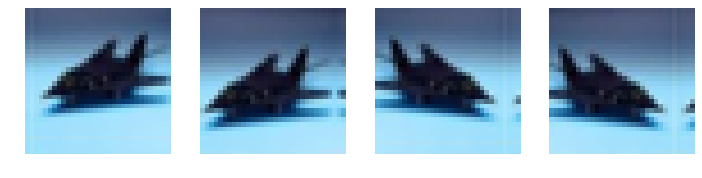

In [47]:
_,axes = plt.subplots(1,4, figsize=(12,9))
for ax in axes.flat: train_tds[1][0].show(ax)

## Normalization and training

To train our network the first step is to normalize our pixels. This makes our cost function faster and easier to optimize [(see Yann le Cun's paper, section 4.3)](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)

Normalization is a pixel transform since it directly modifies the pixels of our input image.

In [0]:
#export
def normalize(x:TensorImage, mean:float,std:float)->TensorImage:   return (x-mean[...,None,None]) / std[...,None,None]
def denormalize(x:TensorImage, mean:float,std:float)->TensorImage: return x*std[...,None,None] + mean[...,None,None]

def normalize_batch(b:Tuple[Tensor,Tensor], mean:float, std:float, do_y:bool=False)->Tuple[Tensor,Tensor]:
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`"
    x,y = b
    x = normalize(x,mean,std)
    if do_y: y = normalize(y,mean,std)
    return x,y

def normalize_funcs(mean:float, std, do_y=False, device=None)->[Callable,Callable]:
    "Create normalize/denormalize func using `mean` and `std`, can specify `do_y` and `device`"
    if device is None: device=default_device
    return (partial(normalize_batch, mean=mean.to(device),std=std.to(device)),
            partial(denormalize,     mean=mean,           std=std))

def transform_datasets(train_ds:Dataset, valid_ds:Dataset, test_ds:Optional[Dataset]=None, 
                       tfms:Optional[Tuple[TfmList,TfmList]]=None, **kwargs:Any):
    "Create train, valid and maybe test DatasetTfm` using `tfms` = (train_tfms,valid_tfms)"
    res = [DatasetTfm(train_ds, tfms[0],  **kwargs),
           DatasetTfm(valid_ds, tfms[1],  **kwargs)]
    if test_ds is not None: res.append(DatasetTfm(test_ds, tfms[1],  **kwargs))
    return res

In [0]:
#export
# CIFAR 10 stats looked up on google 
cifar_stats = (tensor([0.491, 0.482, 0.447]), tensor([0.247, 0.243, 0.261]))
cifar_norm,cifar_denorm = normalize_funcs(*cifar_stats)

def num_cpus()->int:
    "Get number of cpus"
    try:                   return len(os.sched_getaffinity(0))
    except AttributeError: return os.cpu_count()
    
default_cpus = min(16, num_cpus())

In [0]:
#export
@dataclass
class DeviceDataLoader():
    "Binds a `DataLoader` to a `torch.device`"
    dl: DataLoader
    device: torch.device
    tfms: List[Callable]=None
    collate_fn: Callable=data_collate
    def __post_init__(self):
        self.dl.collate_fn=self.collate_fn
        self.tfms = listify(self.tfms)

    def __len__(self)->int: return len(self.dl)
    def __getattr__(self,k:str)->Any: return getattr(self.dl, k)
    
    def add_tfm(self,tfm:Callable)->None:    self.tfms.append(tfm)
    def remove_tfm(self,tfm:Callable)->None: self.tfms.remove(tfm)

    def proc_batch(self,b:Tensor)->Tensor:
        "Proces batch `b` of `TensorImage`"
        b = to_device(b, self.device)
        for f in listify(self.tfms): b = f(b)
        return b

    def __iter__(self):
        "Process and returns items from `DataLoader`"
        self.gen = map(self.proc_batch, self.dl)
        return iter(self.gen)

    @classmethod
    def create(cls, dataset:Dataset, bs:int=1, shuffle:bool=False, device:torch.device=default_device, 
               tfms:TfmList=tfms, num_workers:int=default_cpus, collate_fn:Callable=data_collate, **kwargs:Any):
        "Create DeviceDataLoader from `dataset` with `batch_size` and `shuffle`: processs using `num_workers`"
        return cls(DataLoader(dataset, batch_size=bs, shuffle=shuffle, num_workers=num_workers, **kwargs),
                   device=device, tfms=tfms, collate_fn=collate_fn)

In [0]:
#export
class DataBunch():
    "Bind `train_dl`,`valid_dl` and`test_dl` to `device`. tfms are DL tfms (normalize). `path` is for models."
    def __init__(self, train_dl:DataLoader, valid_dl:DataLoader, test_dl:Optional[DataLoader]=None,
                 device:torch.device=None, tfms:Optional[Collection[Callable]]=None, path:PathOrStr='.'):
        "Bind `train_dl`,`valid_dl` and`test_dl` to `device`. tfms are DL tfms (normalize). `path` is for models."
        self.device = default_device if device is None else device
        self.train_dl = DeviceDataLoader(train_dl, self.device, tfms=tfms)
        self.valid_dl = DeviceDataLoader(valid_dl, self.device, tfms=tfms)
        self.test_dl  = DeviceDataLoader(test_dl,  self.device, tfms=tfms) if test_dl else None
        self.path = Path(path)

    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None,
               path='.', bs=64, ds_tfms=None, num_workers=default_cpus,
               tfms=None, device=None, size=None, **kwargs)->'DataBunch':
        "`DataBunch` factory. `bs` batch size, `ds_tfms` for `Dataset`, `tfms` for `DataLoader`"
        datasets = [train_ds,valid_ds]
        if test_ds is not None: datasets.append(test_ds)
        if ds_tfms: datasets = transform_datasets(*datasets, tfms=ds_tfms, size=size, **kwargs)
        dls = [DataLoader(*o, num_workers=num_workers) for o in
               zip(datasets, (bs,bs*2,bs*2), (True,False,False))]
        return cls(*dls, path=path, device=device, tfms=tfms)
    
    def __getattr__(self,k)->Any: return getattr(self.train_ds, k)
    def holdout(self, is_test:bool=False)->DeviceDataLoader: 
        "Returns correct holdout `Dataset` for test vs validation (`is_test`)"
        return self.test_dl if is_test else self.valid_dl

    @property
    def train_ds(self)->Dataset: return self.train_dl.dl.dataset
    @property
    def valid_ds(self)->Dataset: return self.valid_dl.dl.dataset

def data_from_imagefolder(path:PathOrStr, train:PathOrStr='train', valid:PathOrStr='valid', 
                          test:Optional[PathOrStr]=None, **kwargs:Any):
    "Create `DataBunch` from imagenet style dataset in `path` with `train`,`valid`,`test` subfolders"
    path=Path(path)
    train_ds = ImageDataset.from_folder(path/train)
    datasets = [train_ds, ImageDataset.from_folder(path/valid, classes=train_ds.classes)]
    if test: datasets.append(ImageDataset.from_single_folder(
        path/test,classes=train_ds.classes))
    return DataBunch.create(*datasets, path=path, **kwargs)

In [52]:
data = data_from_imagefolder(PATH, valid='test', bs=bs, train_tfm=tfms, tfms=cifar_norm, num_workers=12)
data.device

device(type='cpu')

tensor(0.) tensor(1.) tensor(0.5021) tensor(0.2509)


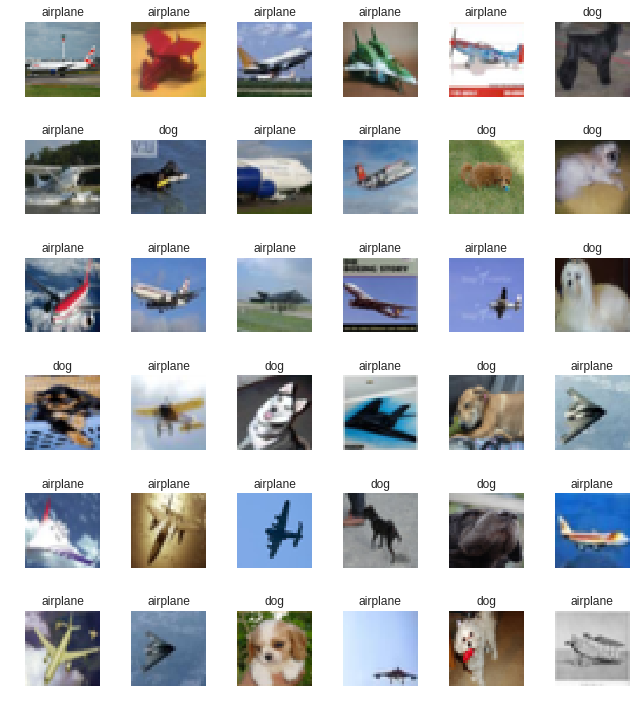

In [53]:
x,y = next(iter(data.train_dl))
x = x.cpu()
x = cifar_denorm(x)
show_images(x,y,6,train_ds.classes, figsize=(9,10))
print(x.min(),x.max(),x.mean(),x.std())

In [0]:
learn = Learner(data, simple_cnn([3,16,16,c], [3,3,3], [2,2,2]))
opt_fn = partial(optim.SGD, momentum=0.9)

In [55]:
learn.fit(1, 0.1, opt_fn=opt_fn)

0 0.5411927700042725


# Darknet

Now we are going to try our transforms on an architecture similar to the [darknet-53](https://pjreddie.com/media/files/papers/yolo.pdf) architecture. Note that it is not the whole architecture, just the part of it that the authors pre-trained on Imagenet (see paper, section 2.2). This is the basis of any modern ResNet based architecture and it is good for experimenting.

If you are interested in a full, step-by-step description of this architecture please refer to a [video explanation](https://youtu.be/ondivPiwQho?t=0h11m07s) in Lesson 12 of Part 2 of the course or a [written transcript](https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-12-215dfbf04a94), courtesy of @hiromi.

In [0]:
#export
def conv_layer(ni:int, nf:int, ks:int=3, stride:int=1)->nn.Sequential:
    "Create Conv2d->BatchNorm2d->LeakyReLu layer: `ni` input, `nf` out filters, `ks` kernel, `stride`:stride"
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True))

class ResLayer(nn.Module):
    "Resnet style `ResLayer`"
    def __init__(self, ni:int):
        "create ResLayer with `ni` inputs"
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

class Darknet(nn.Module):
    "https://github.com/pjreddie/darknet"
    def make_group_layer(self, ch_in:int, num_blocks:int, stride:int=1):
        "starts with conv layer - `ch_in` channels in - then has `num_blocks` `ResLayer`"
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks:int, num_classes:int, nf=32):
        "create darknet with `nf` and `num_blocks` layers"
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x): return self.layers(x)

In [0]:
model = Darknet([1, 2, 4, 4, 2], num_classes=c, nf=16)
learner = Learner(data, model)
opt_fn = partial(optim.SGD, momentum=0.9)

In [58]:
learner.fit(1, 0.1, opt_fn=opt_fn)

0 37.628822326660156


In [0]:
# for lr in (0.1,0.2,0.4,0.8,0.1,0.01):
#     momentum = 0.95 if lr<0.1 else 0.85 if lr>0.5 else 0.9
#     learner.fit(2, lr, opt_fn=partial(optim.SGD, momentum=momentum))

# Fin